<a href="https://colab.research.google.com/github/chohoon901/DeepLearning/blob/main/sunghuncho/ch09_DL_07_%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94_sunghuncho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오토인코더 구현

In [1]:
# 필수 라이브러리
import torch
import torchvision
import torch.nn.functional as F # 가중치가 저장되지 않는 기능적인 부분들을 함수 -> 순전파 코드에서 깔끔하게 구현
from torch import nn, optim # nn : 신경망 모듈, optim : 최적화 함수(SGD, Adam)
from torchvision import transforms, datasets # transforms : 시각 이미지 데이터 전처리와 데이터 증강

In [2]:
# 시각화 관련
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # 3차원 그래프(플롯)를 그리는 용도
from matplotlib import cm # 데이터 포인트(라벨)에 색상을 입히는데 사용 (color_map)
import numpy as np

In [3]:
# 하이퍼파라미터
EPOCH = 10 # 전체 데이터(미니 배치 분할)를 학습시키는 함수
BATCH_SIZE = 64 # 전체 데이터를 몇개씩 모델에 넣어서 학습시킬 것인가?
USE_CUDA = torch.cuda.is_available() # CUDA => NVIDIA GPU 사용 유무
DEVICE= torch.device("cuda" if USE_CUDA else "cpu")
print(f"Using Device : {DEVICE}")

Using Device : cuda


In [4]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    root = './.data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

100%|██████████| 26421880/26421880 [00:01<00:00, 15892760.78it/s]


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 267183.39it/s]


Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5009444.91it/s]


Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21657248.74it/s]


Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



## 오토인코더 모듈 정의

* 오토인코더에는 인코더 & 디코더 두 부분
* nn.Sequential을 사용하여 self.encoder & self.decoder로 두 모듈로 묶어줌

* nn.Sequential
    * 여러 모듈을 하나의 모듈로 묶는 역할
    * 각 레이어를 데이터가 순차적으로 지나갈 때 사용하면 편리 (간결해짐)
    * 계층과 활성화 함수를 정의해주면 순서대로 값을 전달 -> 처리

* **인코더**는 간단한 신경망 -> 분류 모델 유사
    * 28 x 28 -> 784 차원으로 시작해서 점차 줄여나감
    * 마지막 출력 -> 3차원에서 시각화할 수 있도록 특징을 3개만 남김.
    * 인코더의 출력값 = 잠재 변수

![인코더](https://github.com/BigData23th/Data/raw/main/dl_04_01.png)
> 인코더

* **디코더**는 3차원의 잠재 변수를 받아서 다시 784차원의 이미지로 복원
    * 인코더를 거꾸로 만든 것처럼 생겼으며, 출력 차원이 점점 증가하는 것을 볼 수 있음
    * 차이점 : 마지막 출력값을 0과 1 사이로 만들어주는 nn.Sigmoid() 함수가 추가

![디코더](https://github.com/BigData23th/Data/raw/main/dl_04_02.png)
> 디코더

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28,128), # 784 -> 128
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,12),
            nn.ReLU(),
            nn.Linear(12,3),
            # 활성화함수
            # 입력의 특징을 3차원으로 나타내기 위해서 3으로 축소
        )

        self.decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.ReLU(),
            nn.Linear(12,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,28*28), # 784 -> 128
            nn.Sigmoid()
            # 픽셀당 0과 1 사이로 값을 출력
        )
    
    def forward(self, x):
        # 인코더(self.encoder)는 잠재변수인 encoded를 반환
        # 디코더(self.decoder)는 복원 이미지인 decoded를 반환
        # 두 변수 모두 중요하므로, 둘 다 반환
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded # model(?) -> (1) 잠재변수 / (2) 복원된 이미지

In [6]:
autoencoder = Autoencoder().to(DEVICE)

In [7]:
print(autoencoder)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


In [8]:
import torchsummary

torchsummary.summary(autoencoder, (1, 28 * 28), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [64, 1, 128]         100,480
              ReLU-2               [64, 1, 128]               0
            Linear-3                [64, 1, 64]           8,256
              ReLU-4                [64, 1, 64]               0
            Linear-5                [64, 1, 12]             780
              ReLU-6                [64, 1, 12]               0
            Linear-7                 [64, 1, 3]              39
            Linear-8                [64, 1, 12]              48
              ReLU-9                [64, 1, 12]               0
           Linear-10                [64, 1, 64]             832
             ReLU-11                [64, 1, 64]               0
           Linear-12               [64, 1, 128]           8,320
             ReLU-13               [64, 1, 128]               0
           Linear-14               [64,

In [9]:
!pip install torchviz -q
import torchviz

  Preparing metadata (setup.py) ... done


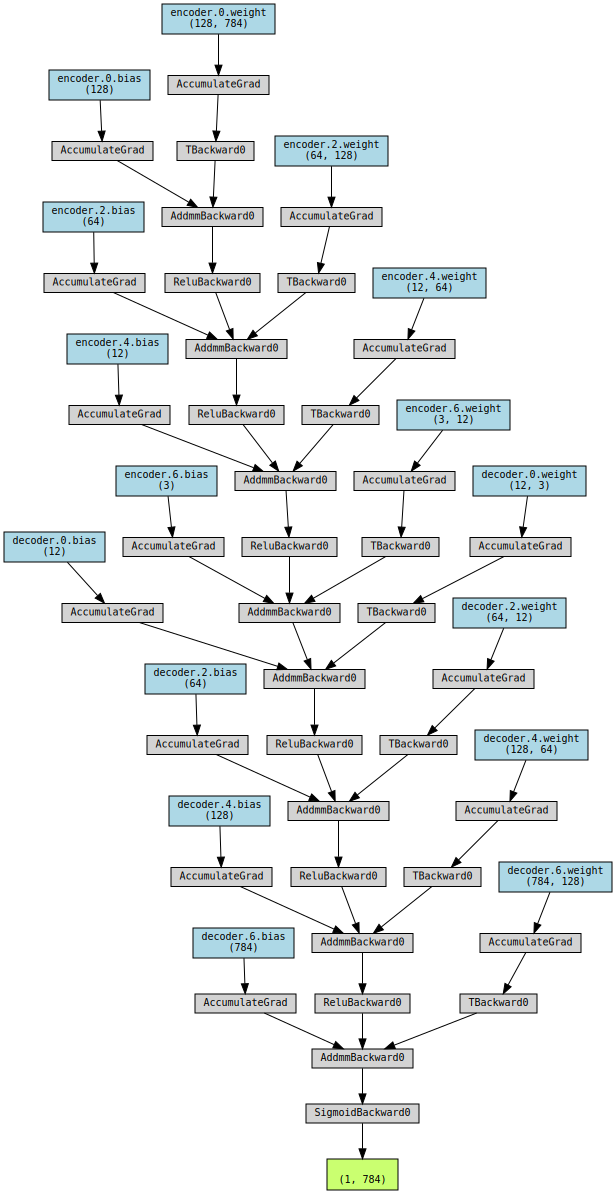

In [10]:
x=torch.randn(1,28*28).to(DEVICE)

torchviz.make_dot(autoencoder(x)[1],params=dict(autoencoder.named_parameters()))

In [11]:
# 최적화 함수 Adam() : SGD의 변형 함수, 학습 중인 기울기를 참고하여 학습 속도를 자동으로 변화시킴
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
# 오차 함수
# nn.MSELoss : 두 개의 같은 크기의 행렬을 받아, 각 자리의 차이에 제곱해서 평균을 구해주는 객체를 생성
criterion = nn.MSELoss()

In [12]:
# 한 에포크 epoch 가 완료될 때마다, 복원이 어떻게 되었는지 시각화 (정확도 X)
view_data = trainset.data[:5].view(-1, 28 * 28) # 학습 데이터셋에 있는 5개의 이미지를 가져와서 바로 모델에 투입

view_data = view_data.type(torch.FloatTensor)/255. # 픽셀의 색상값이 0~255 -> 우리가 만드는 모델은 0~1를 인식

In [13]:
view_data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [14]:
# 학습함수
def train(autoencoder, train_loader): # 모델, 데이터셋
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader): # 인덱스, 값(x, label)
        # 입력인 x, 대상 레이블인 y -> 둘다 원본 이미지 x
        x = x.view(-1, 28 * 28).to(DEVICE)
        y = x.view(-1, 28 * 28).to(DEVICE) # <- 원본 이미지
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        # 오차값 : 디코더에서 나온 복원 이미지 decoded와 원본 이미지 y -> 차이의 제곱
        loss = criterion(decoded, y)
        optimizer.zero_grad() # 기울기 정보 초기화
        loss.backward() # 기울기 구하기 (오차 역전파)
        optimizer.step() # 최적화 진행

## 복원된 이미지 확인

[Epoch 1]


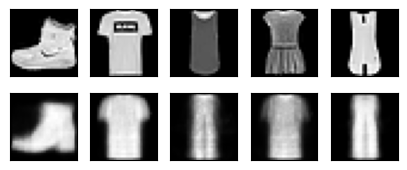

[Epoch 2]


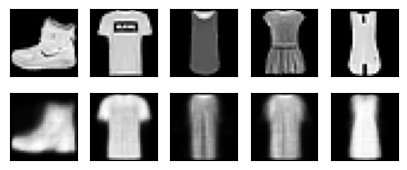

[Epoch 3]


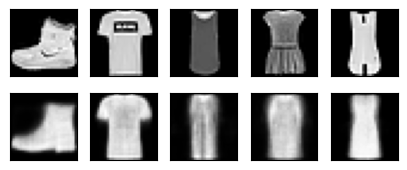

[Epoch 4]


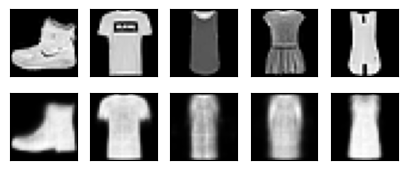

[Epoch 5]


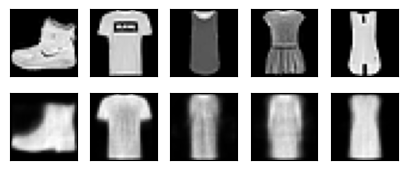

[Epoch 6]


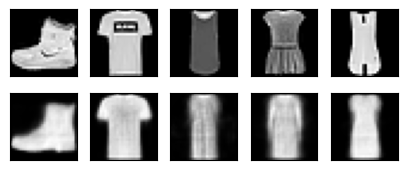

[Epoch 7]


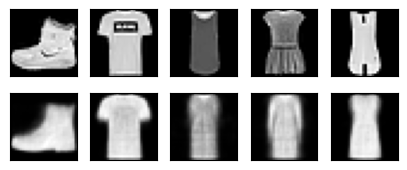

[Epoch 8]


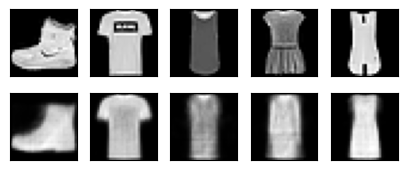

[Epoch 9]


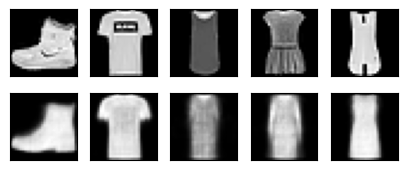

[Epoch 10]


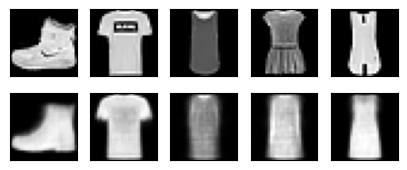

In [15]:
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    # 시각화 -> 복원 이미지 (디코더에서 나온 이미지)
    test_x = view_data.to(DEVICE)
    # encoded_data, decoded_data = autoencoder(test_x)
    _, decoded_data = autoencoder(test_x)
    # 시각화를 위해 구분해놓은 5개의 이미지를 한 에포크만큼 학습을 마친 모델에 넣어서
    # 복원 이미지를 확인
    vd = view_data.data.to('cpu').numpy()
    dd = decoded_data.to('cpu').data.numpy()
    f, a = plt.subplots(2, 5, figsize=(5, 2)) # 행(세로) 2개, 열(가로) 5개
    print(f"[Epoch {epoch}]")
    # 원본 이미지 표시 (view_data)
    for i in range(5):
        # (1) view_data.data.to("cpu") : DEVICE로 보냈던 view_data를 cpu로 가져오겠다
        # (2) numpy() : tensor 데이터를 numpy array (ndarray) // matpoltlib으로 시각화하려면 tensor X, ndarray
        # (3) [i]는 각각 열에 한 개씩의 이미지를 연결
        # (4) np.reshape({IMG}, (28, 28)) -> 하나의 이미지를 다시 28 x 28 픽셀의 정사각형 이미지로 나타내겠다
        img = np.reshape(vd[i], (28,28))
        # subplot의 첫번째(0) 행에 i번째 열에 이미지를 표시(imshow)
        a[0][i].imshow(img, cmap='gray') # 회색조
        a[0][i].set_xticks(()); a[0][i].set_yticks(()) # 축의 별도 표시를 없애줌
    # 디코딩(복원) 이미지 표시 (decoded_data)
    for i in range(5):
        # (1) decoded_data.to("cpu") : DEVICE에 존재하는 model의 결과물 decoded_data를 cpu로 가져오겠다
        # (2) numpy() : tensor 데이터를 numpy array (ndarray) // matpoltlib으로 시각화하려면 tensor X, ndarray
        # (3) [i]는 각각 열에 한 개씩의 이미지를 연결
        # (4) np.reshape({IMG}, (28, 28)) -> 하나의 이미지를 다시 28 x 28 픽셀의 정사각형 이미지로 나타내겠다
        img = np.reshape(dd[i], (28,28))
        # subplot의 두번째(1) 행에 i번째 열에 이미지를 표시(imshow)
        a[1][i].imshow(img, cmap='gray') # 회색조
        a[1][i].set_xticks(()); a[1][i].set_yticks(()) # 축의 별도 표시를 없애줌
    plt.show() # subplot을 불러오기

## 잠재 변수 확인
* 잠재 변수들이 3차원에 어떻게 분포되는지 확인

In [16]:
# 잠재변수를 3D 플롯으로 시각화
# 학습 데이터셋으로부터 원본 이미지 200개 준비
view_data = trainset.data[200:400].view(-1,28*28)
view_data = view_data.type(torch.FloatTensor) / 255

In [17]:
test_x = view_data.to(DEVICE) # 모델이 있는 DEVICE로 보내기
encoded_data, _ = autoencoder(test_x) # encoded_data : 잠재변수, decoded_data : 복원된 이미지


In [18]:
encoded_data

tensor([[ 5.0093e+00,  8.3320e-01,  1.4705e+00],
        [ 1.2408e+00, -2.4408e+00, -8.4081e-01],
        [ 1.2124e-01,  3.1191e+00,  7.2035e-01],
        [-6.1066e-01,  2.8944e+00,  6.0186e+00],
        [ 3.3374e-01,  2.5794e+00,  5.3490e+00],
        [-2.2858e+00,  4.4673e+00,  6.3235e+00],
        [ 1.2366e+00,  6.7838e+00,  3.4684e+00],
        [ 4.7571e-01,  5.0387e+00,  1.3632e+00],
        [-6.0774e-01, -2.2278e+00,  2.6892e+00],
        [ 5.4266e+00,  4.6990e+00,  2.0589e-01],
        [ 1.5977e+00, -2.1676e+00, -2.3824e+00],
        [ 5.2089e+00,  2.8799e+00,  2.1797e+00],
        [ 1.8169e+00,  3.5630e-01,  3.9301e+00],
        [-2.3037e+00, -9.1255e-01,  2.0474e+00],
        [ 3.3180e+00, -1.2185e-01,  3.4474e+00],
        [ 2.3137e+00,  3.0185e+00,  1.6780e+00],
        [ 1.3756e+00, -2.9808e+00,  4.9630e+00],
        [ 6.9486e-02, -1.7485e+00,  2.7398e-01],
        [-1.4438e+00,  8.9862e-01,  7.8121e+00],
        [ 1.6998e+00,  8.8367e+00,  2.4082e+00],
        [ 1.7357e+00

In [19]:
encoded_data = encoded_data.to('cpu')

In [20]:
# 잠재 변수 레이블을 붙이고자 딕셔너리를 준비
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [21]:
# Axes3D() 함수 -> 3차원 액자
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

# 잠재 변수의 각 차원 (3차원) X, Y, Z를 따로 추출하여 numpy 행렬로 변환
X = encoded_data.data[:, 0].numpy() # plt
Y = encoded_data.data[:, 1].numpy() # plt
Z = encoded_data.data[:, 2].numpy() # plt

labels = trainset.targets[200:400].numpy()

for x, y, z, s in zip(X, Y, Z, labels):
    name = CLASSES[s] # labels
    color = cm.rainbow(int(255*s/9))
    ax.text(x, y, z, name, backgroundcolor=color)

ax.set_xlim(X.min(), X.max()) # 액자 안의 x, y, z의 최솟값 & 최댓값 지정
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())

ax.view_init(45, 45) # 각도로 입력
plt.show()

<Figure size 1000x800 with 0 Axes>

# 오토인코더로 망가진 이미지 복원

* 오토인코더는 일종의 '압축'을 진행
    * 압축 = 데이터의 특성에 우선순위를 매기고, 낮은 순위의 데이터를 버린다는 뜻
* 잡음 제거 오토인코더 `denoising autoencoder`
    * 중요한 특징을 추출하는 오토인코더의 특성을 이용하여, 비교적 덜 중요한 데이터인 잡음을 제거
    * 학습할 때 입력에 잡음을 더하는 방식으로 복원 능력 강화

In [22]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
import numpy as np

In [23]:
# 하이퍼파라미터
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE= torch.device("cuda" if USE_CUDA else "cpu")
print(f"Using Device : {DEVICE}")

Using Device : cuda


In [24]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    root = './.data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

In [26]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28,128), # 784 -> 128
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,12),
            nn.ReLU(),
            nn.Linear(12,3),
            # 활성화함수
            # 입력의 특징을 3차원으로 나타내기 위해서 3으로 축소
        )

        self.decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.ReLU(),
            nn.Linear(12,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,28*28), # 784 -> 128
            nn.Sigmoid()
            # 픽셀당 0과 1 사이로 값을 출력
        )
    
    def forward(self, x):
        # 인코더(self.encoder)는 잠재변수인 encoded를 반환
        # 디코더(self.decoder)는 복원 이미지인 decoded를 반환
        # 두 변수 모두 중요하므로, 둘 다 반환
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded # model(?) -> (1) 잠재변수 / (2) 복원된 이미지

In [27]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [28]:
# 노이즈 더하는 코드
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

In [33]:
# 훈련 함수
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader):
        noisy_x = add_noise(x) # 입력에 노이즈 더하기
        noisy_x = noisy_x.view(-1, 28*28).to(DEVICE) # 모델에 들어갈 수 있도록 모양 변경
        y = x.view(-1, 28*28).to(DEVICE) # 정답값 (원본)

        label = label.to(DEVICE)
        encoded, decoded = autoencoder(noisy_x)
        

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item() # batch들의 평균 로스 계산
    return avg_loss / len(train_loader)

In [34]:
for epoch in range(1, EPOCH+1):
    loss = train(autoencoder, train_loader)
    print(f"[Epoch {epoch} loss: {loss}]")

[Epoch 1 loss: 0.04018064466779674]
[Epoch 2 loss: 0.027279766711360738]
[Epoch 3 loss: 0.025029015709469315]
[Epoch 4 loss: 0.024294011229311605]
[Epoch 5 loss: 0.024022636847741315]
[Epoch 6 loss: 0.023676282867217367]
[Epoch 7 loss: 0.02351793402166509]
[Epoch 8 loss: 0.023336692673485798]
[Epoch 9 loss: 0.023196176433169256]
[Epoch 10 loss: 0.02324511234495622]


## 잡음 제거 시각화하기

In [35]:
testset = datasets.FashionMNIST(
    root = './.data/',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

In [36]:
# 텍스트셋에서 0번째 이미지 한 장 -> 모델의 입력 (차원, 값의 범위)
sample_data = testset.data[0].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.


In [37]:
sample_data

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [38]:
original_x = sample_data[0] # 0: 이미지, 1: 라벨
noisy_x = add_noise(original_x).to(DEVICE)
noisy_x

tensor([ 4.2762e-01,  1.5759e-01, -9.1101e-02,  6.2784e-02,  1.0360e-01,
         5.0513e-01, -1.7479e-01,  1.4193e-01,  2.1108e-01, -3.3930e-02,
         8.4800e-02, -5.9751e-02, -5.5482e-02,  1.4393e-01,  1.1943e-01,
         1.5016e-01, -2.2086e-01, -1.5347e-01,  1.8183e-01, -9.9480e-02,
        -4.9892e-02,  2.0106e-01,  1.9569e-02,  1.7725e-01, -1.7908e-01,
        -1.1195e-01,  9.4938e-02, -2.5133e-01,  3.6144e-01,  8.0419e-02,
         2.2355e-01, -7.2612e-02,  7.1863e-02,  7.0474e-02, -7.4266e-02,
        -1.5314e-02, -2.1380e-01, -1.3990e-01, -4.1070e-01,  9.1738e-02,
         5.4780e-02, -1.9983e-01,  6.0765e-02, -9.2927e-02, -1.7126e-01,
         2.8181e-01, -9.0335e-02, -3.2731e-01,  1.6590e-01,  1.5105e-01,
        -3.3660e-01,  3.0174e-01, -2.9620e-01, -1.0999e-02, -2.6620e-01,
        -9.1687e-02,  1.2634e-01, -3.5681e-02,  7.1974e-04,  2.4165e-01,
        -3.3991e-03,  2.3785e-01, -1.2464e-01,  2.8842e-01, -9.4787e-02,
         2.8753e-01, -1.5918e-01,  1.2686e-01,  6.4

In [39]:
# 모델에 통과
_, recovered_x = autoencoder(noisy_x) # 잠재변수, 복원된 이미지

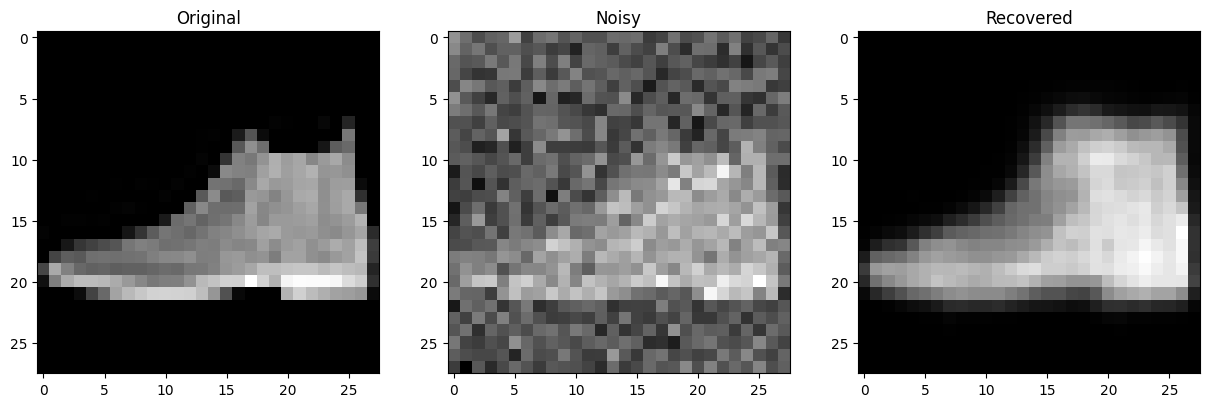

In [40]:
f, a = plt.subplots(1, 3, figsize=(15, 15)) # 이미지 3개

# 시각화를 위해 넘파이 행렬로 바꿔줍니다.
original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

# 원본 사진
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

# 오염된 원본 사진
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

# 복원된 사진
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()

In [41]:
def show_img(index):
    sample_data = testset.data[index].view(-1, 28*28)
    sample_data = sample_data.type(torch.FloatTensor)/255.
    original_x = sample_data[0]
    noisy_x = add_noise(original_x).to(DEVICE)
    _, recovered_x = autoencoder(noisy_x)
    f, a = plt.subplots(1, 3, figsize=(15, 15))

    original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
    noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
    recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

    a[0].set_title('Original')
    a[0].imshow(original_img, cmap='gray')

    a[1].set_title('Noisy')
    a[1].imshow(noisy_img, cmap='gray')

    a[2].set_title('Recovered')
    a[2].imshow(recovered_img, cmap='gray')

    plt.show()

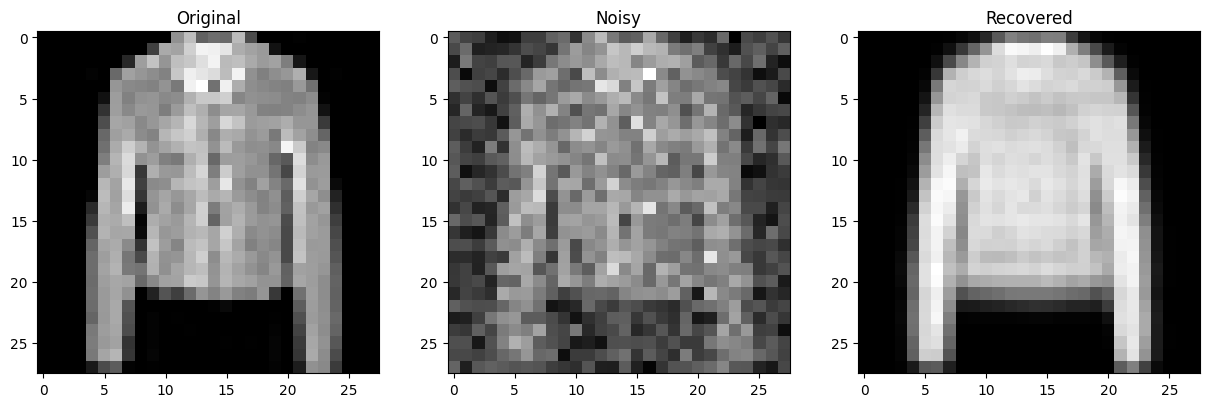

In [42]:
show_img(10)